# T20 Cricket Match Score Prediction
## Using Linear Regression, Decision Tree, and Neural Network

## Import Libraries

In [1]:
!pip install kneed

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import PowerTransformer
from scipy import stats


## Load Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
matchscore= pd.read_csv('/content/drive/MyDrive/t20_cricket_match_score_prediction.csv')
matchscore.head()




,Match ID,Overs Played,Wickets Lost,Run Rate,Home/Away,Opponent Strength,Pitch Condition,Weather,Predicted Score
0,1,7,1,11.04,Away,3,Bowling,Sunny,82
1,2,20,10,11.87,Home,5,Bowling,Sunny,204
2,3,15,7,6.14,Home,7,Balanced,Sunny,105
3,4,11,8,8.84,Home,9,Batting,Cloudy,121
4,5,8,0,9.56,Home,2,Balanced,Sunny,104


In [5]:
print ('Shape of the dataset is {}. This dataset contains {} rows and {} columns.'.format(matchscore.shape,matchscore.shape[0],matchscore.shape[1]))

Shape of the dataset is (1500, 9). This dataset contains 1500 rows and 9 columns.


## Exploratory Data Analysis (EDA)

In [6]:
# Dataset information
matchscore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Match ID           1500 non-null   int64  
 1   Overs Played       1500 non-null   int64  
 2   Wickets Lost       1500 non-null   int64  
 3   Run Rate           1500 non-null   float64
 4   Home/Away          1500 non-null   object 
 5   Opponent Strength  1500 non-null   int64  
 6   Pitch Condition    1500 non-null   object 
 7   Weather            1500 non-null   object 
 8   Predicted Score    1500 non-null   int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 105.6+ KB


In [7]:
# Statistical summary
matchscore.describe()

,Match ID,Overs Played,Wickets Lost,Run Rate,Opponent Strength,Predicted Score
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,750.500000,10.255333,4.894000,9.964173,5.499333,112.637333
std,433.157015,5.864219,3.078487,2.880189,2.891293,71.886356
min,1.000000,1.000000,0.000000,5.000000,1.000000,6.000000
25%,375.750000,5.000000,2.000000,7.507500,3.000000,56.000000
50%,750.500000,10.000000,5.000000,9.915000,6.000000,97.000000
75%,1125.250000,15.000000,8.000000,12.480000,8.000000,157.000000
max,1500.000000,20.000000,10.000000,15.000000,10.000000,382.000000


In [8]:
# Check for null values
print("Null values in dataset:")
print(matchscore.isnull().sum())

Null values in dataset:
Match ID             0
Overs Played         0
Wickets Lost         0
Run Rate             0
Home/Away            0
Opponent Strength    0
Pitch Condition      0
Weather              0
Predicted Score      0
dtype: int64


In [9]:
class_counts = matchscore['Predicted Score'].value_counts()
print(class_counts)

Predicted Score
33     16
90     16
35     15
25     15
76     14
       ..
231     1
307     1
191     1
239     1
303     1
Name: count, Length: 298, dtype: int64


### Categorical Data Analysis

In [10]:
# Selecting categorical features
categorical_data = matchscore.select_dtypes(include='object')
categorical_features = categorical_data.columns.tolist()

print(f'There are {len(categorical_features)} categorical features:', '\n')
print(categorical_features)


There are 3 categorical features: 

['Home/Away', 'Pitch Condition', 'Weather']


In [11]:
unique_counts=categorical_data.nunique()
print(unique_counts)

Home/Away          2
Pitch Condition    3
Weather            3
dtype: int64


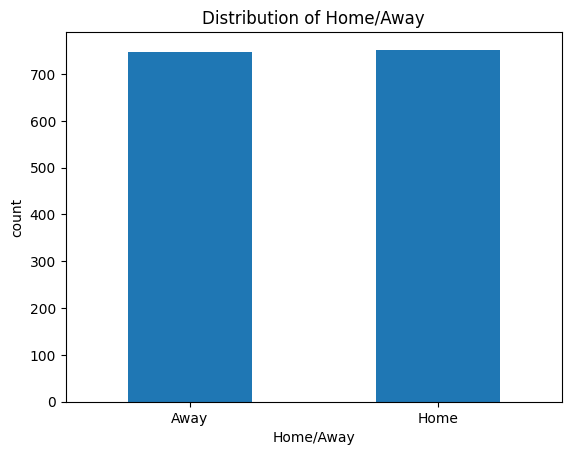

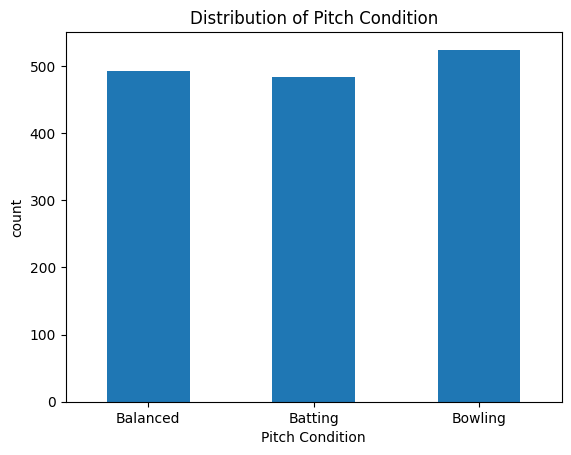

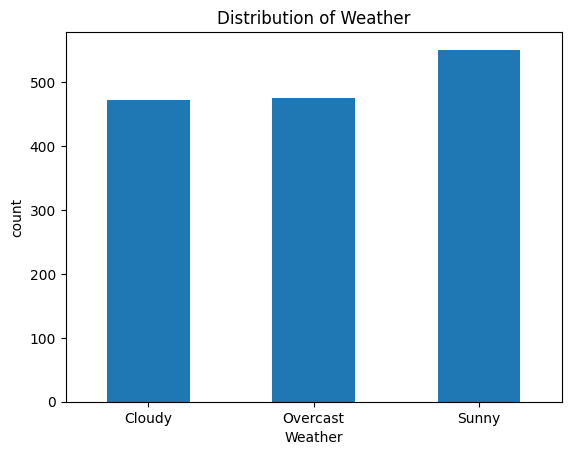

In [12]:
#barplot of unique categorical value
for col in categorical_features:
    plt.title(f'Distribution of {col}')
    categorical_data[col].value_counts().sort_index().plot(kind='bar', rot=0, xlabel=col,ylabel='count')
    plt.show()

### Numerical Data Analysis

In [13]:
# Selecting numerical features
numerical_data = matchscore.select_dtypes(include='number')
numerical_features = numerical_data.columns.tolist()

print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)

There are 6 numerical features: 

['Match ID', 'Overs Played', 'Wickets Lost', 'Run Rate', 'Opponent Strength', 'Predicted Score']


In [14]:
numerical_data.skew()

,0
Match ID,0.000000
Overs Played,0.037554
Wickets Lost,0.021942
Run Rate,0.004770
Opponent Strength,0.009806
Predicted Score,0.877995


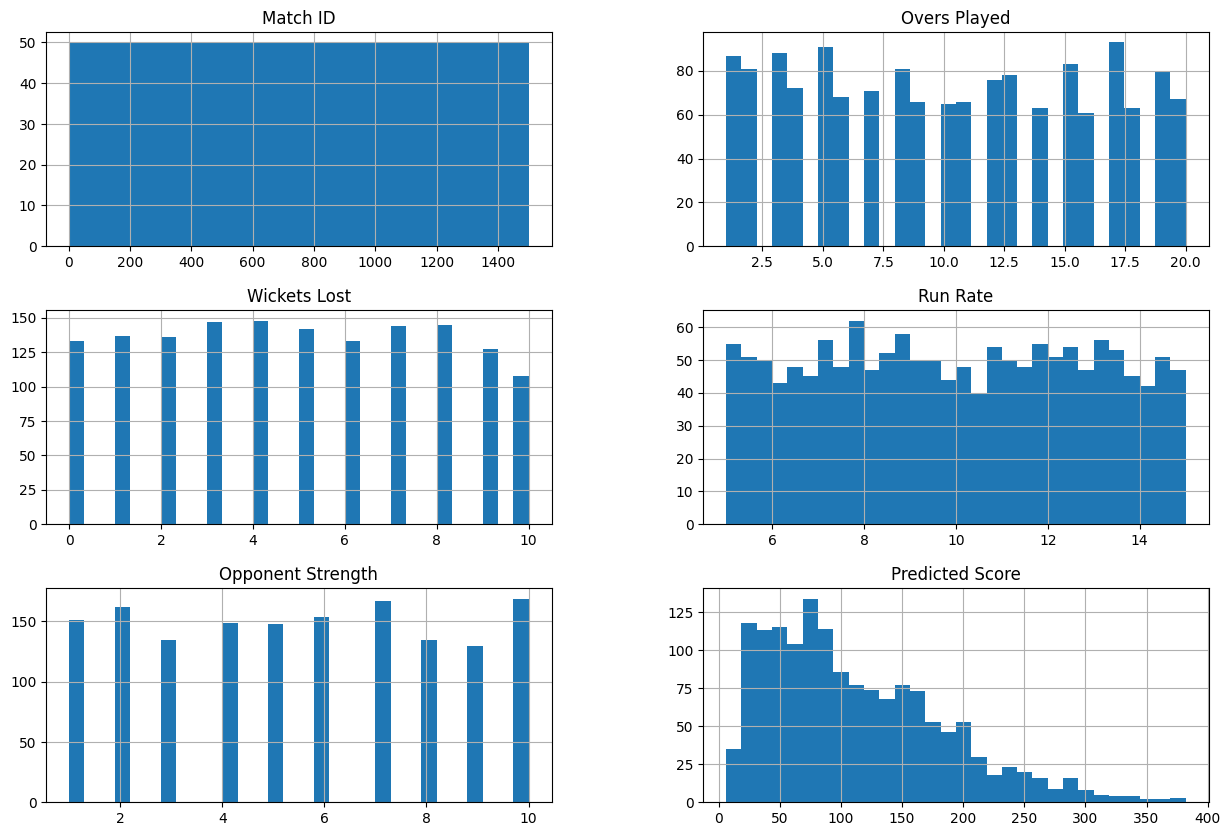

In [15]:
# Histograms of numerical features
numerical_data.hist(figsize=(15, 10), bins=30)
plt.show()

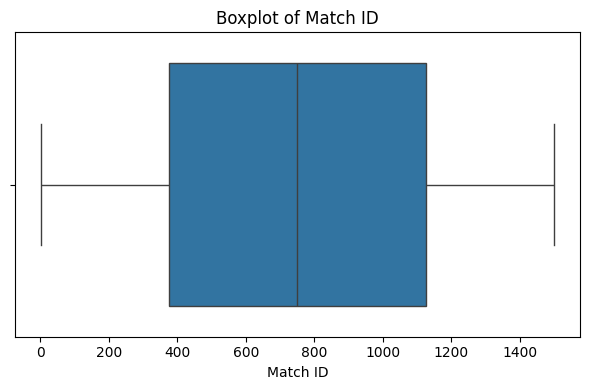

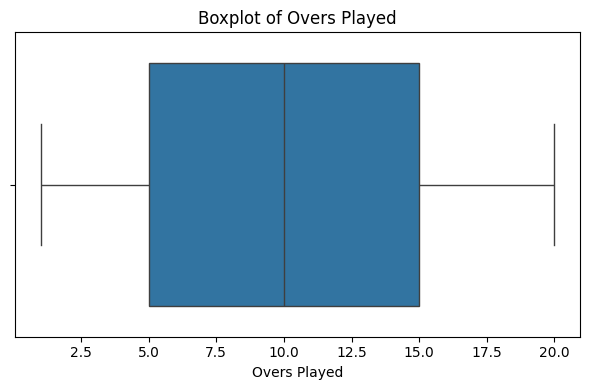

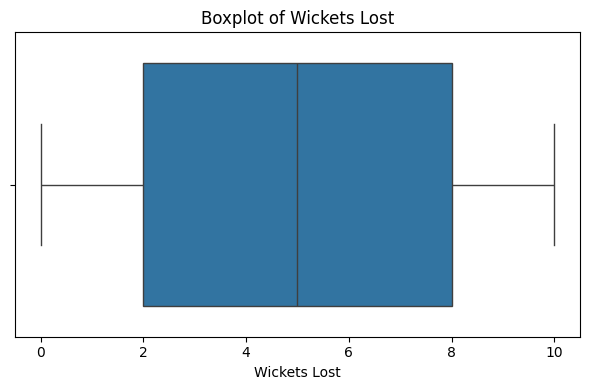

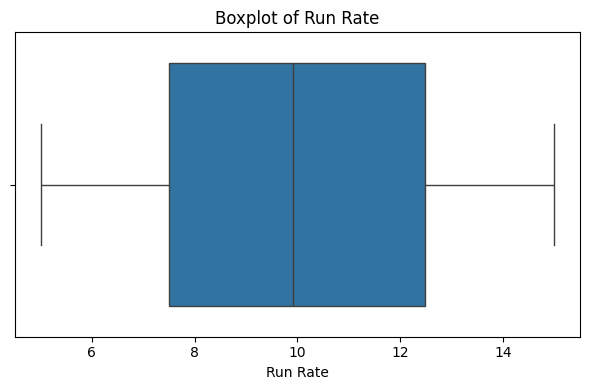

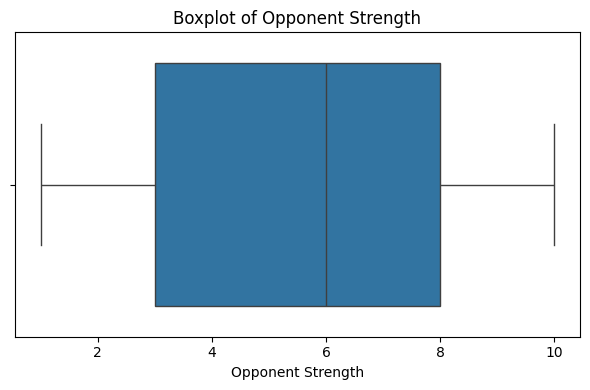

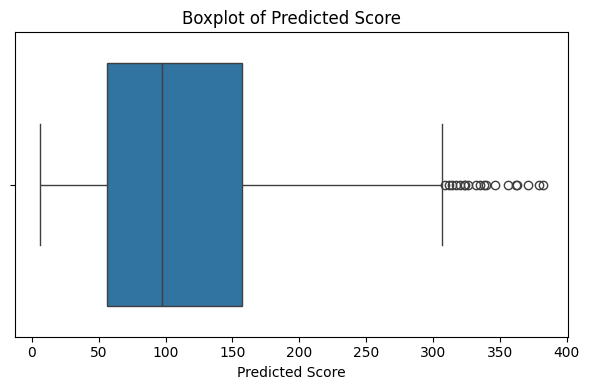

In [16]:
# Boxplots for numerical features
for col in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data= matchscore, x=col)
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

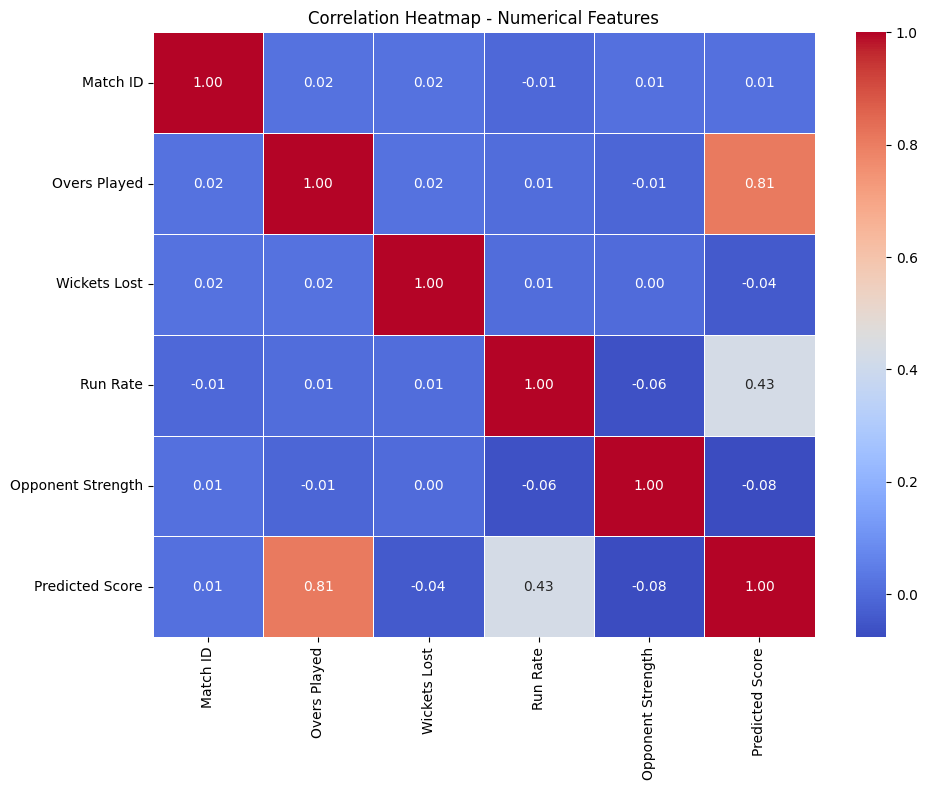

In [17]:
# Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
corr = numerical_data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap - Numerical Features')
plt.tight_layout()
plt.show()

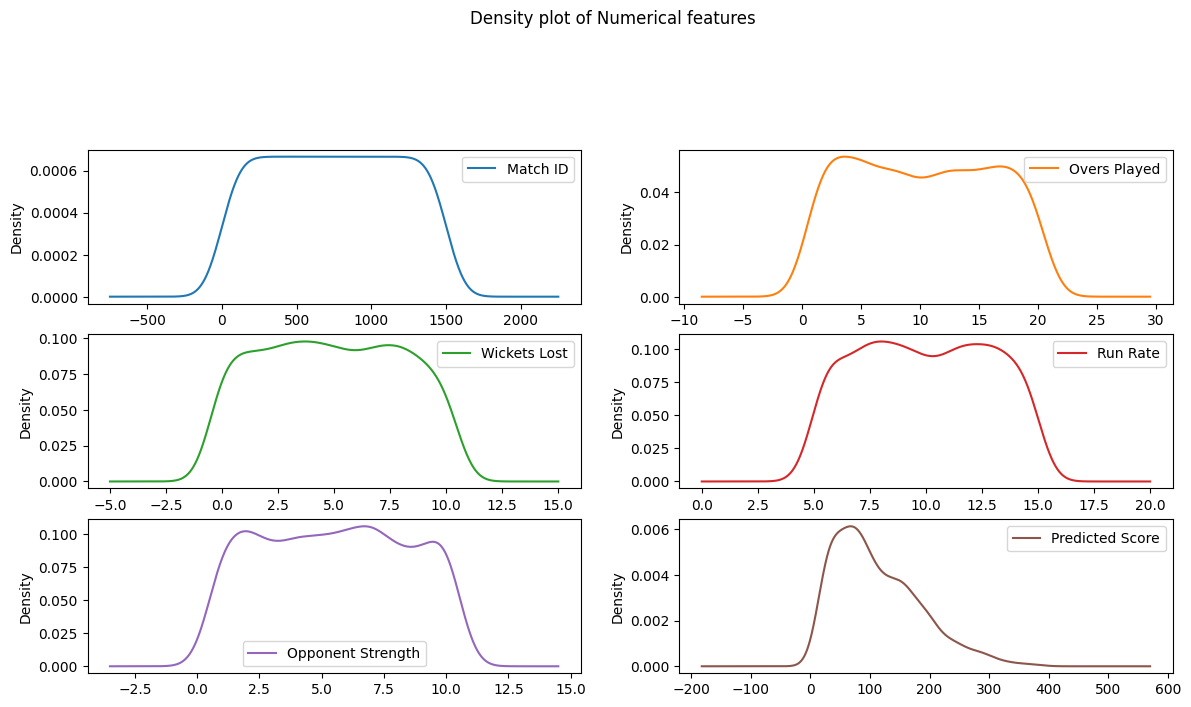

In [18]:
numerical_data.plot(kind='density',figsize=(14,14),subplots=True,layout=(6,2),title="Density plot of Numerical features",sharex=False)
plt.show()

### Target Variable Analysis

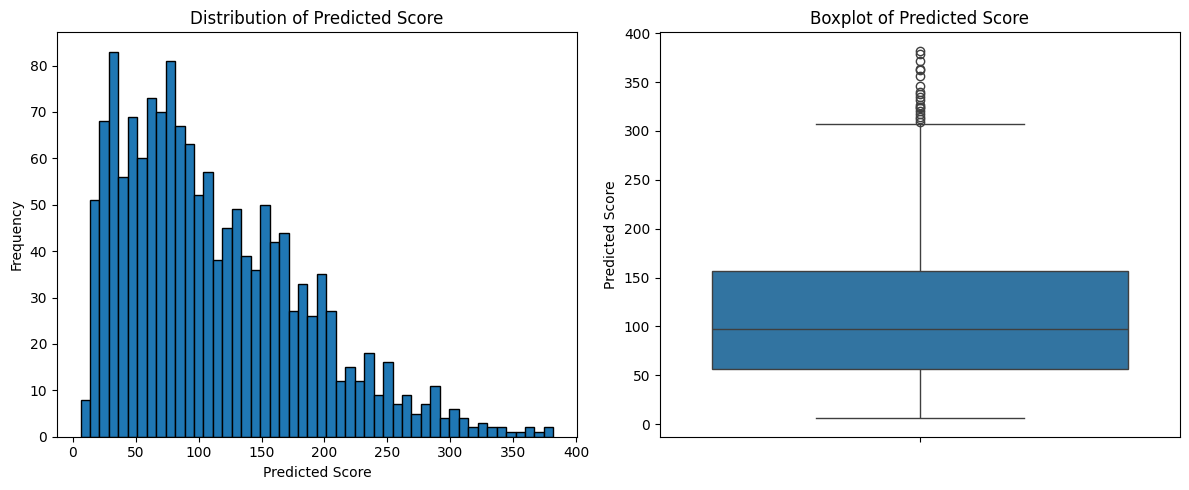

Target Variable Statistics:
count    1500.000000
mean      112.637333
std        71.886356
min         6.000000
25%        56.000000
50%        97.000000
75%       157.000000
max       382.000000
Name: Predicted Score, dtype: float64


In [19]:
# Distribution of target variable (Predicted Score)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(matchscore['Predicted Score'], bins=50, edgecolor='black')
plt.title('Distribution of Predicted Score')
plt.xlabel('Predicted Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(data=matchscore, y='Predicted Score')
plt.title('Boxplot of Predicted Score')

plt.tight_layout()
plt.show()

print(f"Target Variable Statistics:")
print(matchscore['Predicted Score'].describe())

In [20]:
unique_target= matchscore['Predicted Score'].nunique()
print(unique_target)

298


## Feature Engineering and Preprocessing

In [21]:
# Drop Match ID as it's not useful for prediction
matchscore_processed = matchscore.drop(columns=['Match ID'])

# Define target and features
y = matchscore_processed['Predicted Score']
X = matchscore_processed.drop(columns=['Predicted Score'])

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)

Categorical features: ['Home/Away', 'Pitch Condition', 'Weather']
Numerical features: ['Overs Played', 'Wickets Lost', 'Run Rate', 'Opponent Strength']


In [22]:
# Preprocessing pipeline
preprocess = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

X_processed = preprocess.fit_transform(X)
print("Processed feature shape:", X_processed.shape)

Processed feature shape: (1500, 12)


## Data Splitting

In [23]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (1050, 12)
Test shape: (450, 12)


# Transformation Analysis & Comprehensive Model Comparison

# : Linear Regression - WITH Skew Handling

SKEWNESS ANALYSIS

Skewness values for numerical features:
Predicted Score      0.877995
Overs Played         0.037554
Wickets Lost         0.021942
Opponent Strength    0.009806
Run Rate             0.004770
Match ID             0.000000
dtype: float64

SKEWNESS INTERPRETATION:
  • |skew| < 0.5  : Approximately symmetric (normal)
  • 0.5 < |skew| < 1.0 : Moderately skewed
  • |skew| > 1.0 : Highly skewed

Features with |skew| > 0.5 (need transformation):
  • Predicted Score: 0.878


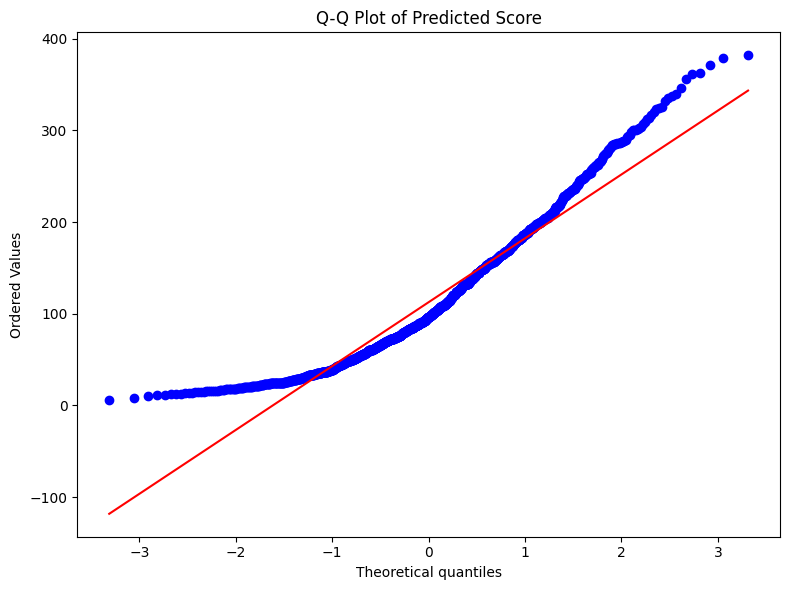


Target Variable Skewness: 0.878
⚠️  Target is skewed - transformation recommended!


In [24]:
print("SKEWNESS ANALYSIS")
# Calculate skewness for all numerical features
skewness_values = numerical_data.skew().sort_values(ascending=False)
print("\nSkewness values for numerical features:")
print(skewness_values)

print("\n" + "="*60)
print("SKEWNESS INTERPRETATION:")
print("  • |skew| < 0.5  : Approximately symmetric (normal)")
print("  • 0.5 < |skew| < 1.0 : Moderately skewed")
print("  • |skew| > 1.0 : Highly skewed")
print("="*60 + "\n")

# Identify highly skewed features
highly_skewed = skewness_values[abs(skewness_values) > 0.5]
print(f"Features with |skew| > 0.5 (need transformation):")
for feature, skew_val in highly_skewed.items():
    print(f"  • {feature}: {skew_val:.3f}")

# Q-Q plot for target variable
plt.figure(figsize=(8, 6))
stats.probplot(matchscore['Predicted Score'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Predicted Score')
plt.tight_layout()
plt.show()

target_skew = matchscore['Predicted Score'].skew()
print(f"\nTarget Variable Skewness: {target_skew:.3f}")
if abs(target_skew) > 0.5:
    print("⚠️  Target is skewed - transformation recommended!")
else:
    print("✓ Target is approximately normal")


In [25]:
## Cell: APPLY YEO-JOHNSON TRANSFORMATION
print("APPLYING SKEWNESS TRANSFORMATIONS")
# Create a copy for transformation
matchscore_transformed = matchscore.copy()

# Identify features to transform (exclude Match ID and target)
features_to_check = [col for col in numerical_features
                     if col not in ['Match ID', 'Predicted Score']]

# Calculate skewness
feature_skewness = matchscore_transformed[features_to_check].skew()
# Features that need transformation (|skew| > 0.5)
skewed_features = feature_skewness[abs(feature_skewness) > 0.5].index.tolist()

print(f"\nFeatures requiring transformation (|skew| > 0.5):")
for feat in skewed_features:
    print(f"  • {feat}: skew = {feature_skewness[feat]:.3f}")

# Apply Yeo-Johnson transformation
if len(skewed_features) > 0:
    pt = PowerTransformer(method='yeo-johnson', standardize=False)

    matchscore_transformed[skewed_features] = pt.fit_transform(
        matchscore_transformed[skewed_features]
    )

    print(f"\n✓ Applied Yeo-Johnson transformation to {len(skewed_features)} features")

    # Check skewness after transformation
    print("\nSkewness AFTER transformation:")
    for feat in skewed_features:
        new_skew = matchscore_transformed[feat].skew()
        old_skew = feature_skewness[feat]
        improvement = ((abs(old_skew) - abs(new_skew)) / abs(old_skew) * 100)
        print(f"  • {feat}: {old_skew:.3f} → {new_skew:.3f} "
              f"({improvement:.1f}% improvement)")
else:
    print("\n✓ No features require transformation")




APPLYING SKEWNESS TRANSFORMATIONS

Features requiring transformation (|skew| > 0.5):

✓ No features require transformation


In [26]:
## Cell: PREPROCESSING - WITH SKEW HANDLING (Version 1)

print("PREPROCESSING WITH SKEW HANDLING")
matchscore_processed_skew = matchscore_processed
# Define target and features
y_skew = matchscore_processed_skew['Predicted Score']
X_skew = matchscore_processed_skew.drop(columns=['Predicted Score'])

# Identify features
categorical_features_skew = X_skew.select_dtypes(include=['object']).columns.tolist()
numerical_features_skew = X_skew.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing pipeline
preprocess_skew = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features_skew),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_skew)
])

X_processed_skew = preprocess_skew.fit_transform(X_skew)
print(f"Processed feature shape: {X_processed_skew.shape}")

# Train-test split
X_train_skew, X_test_skew, y_train_skew, y_test_skew = train_test_split(
    X_processed_skew, y_skew, test_size=0.3, random_state=42
)

print(f"Train shape: {X_train_skew.shape}")
print(f"Test shape: {X_test_skew.shape}")
## Cell: PREPROCESSING - WITHOUT SKEW HANDLING (Version 2 - Original)

print("PREPROCESSING WITHOUT SKEW HANDLING (Original)")
print("="*60)

# Original preprocessing (keep your existing code)
matchscore_processed_orig = matchscore.drop(columns=['Match ID'])
y_orig = matchscore_processed_orig['Predicted Score']
X_orig = matchscore_processed_orig.drop(columns=['Predicted Score'])

categorical_features_orig = X_orig.select_dtypes(include=['object']).columns.tolist()
numerical_features_orig = X_orig.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocess_orig = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features_orig),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_orig)
])

X_processed_orig = preprocess_orig.fit_transform(X_orig)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_processed_orig, y_orig, test_size=0.3, random_state=42
)

print(f"Train shape: {X_train_orig.shape}")
print(f"Test shape: {X_test_orig.shape}")


PREPROCESSING WITH SKEW HANDLING
Processed feature shape: (1500, 12)
Train shape: (1050, 12)
Test shape: (450, 12)
PREPROCESSING WITHOUT SKEW HANDLING (Original)
Train shape: (1050, 12)
Test shape: (450, 12)


## Model 1: Linear Regression without skew

In [27]:
# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluation
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

print("Linear Regression Results:")
print(f"MSE: {lr_mse:.2f}")
print(f"RMSE: {lr_rmse:.2f}")
print(f"MAE: {lr_mae:.2f}")
print(f"R² Score: {lr_r2:.4f}")

Linear Regression Results:
MSE: 444.13
RMSE: 21.07
MAE: 15.76
R² Score: 0.9129


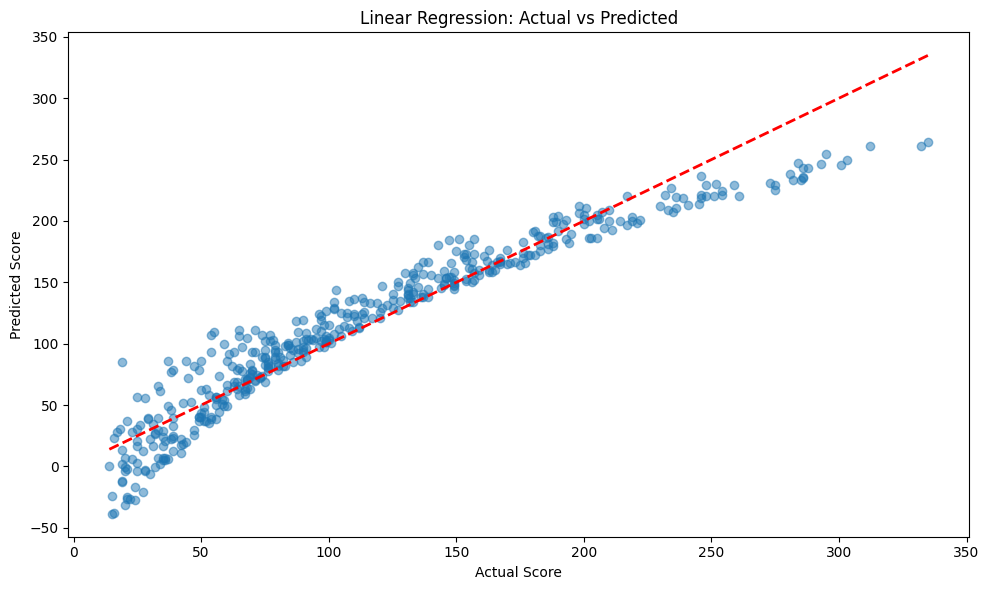

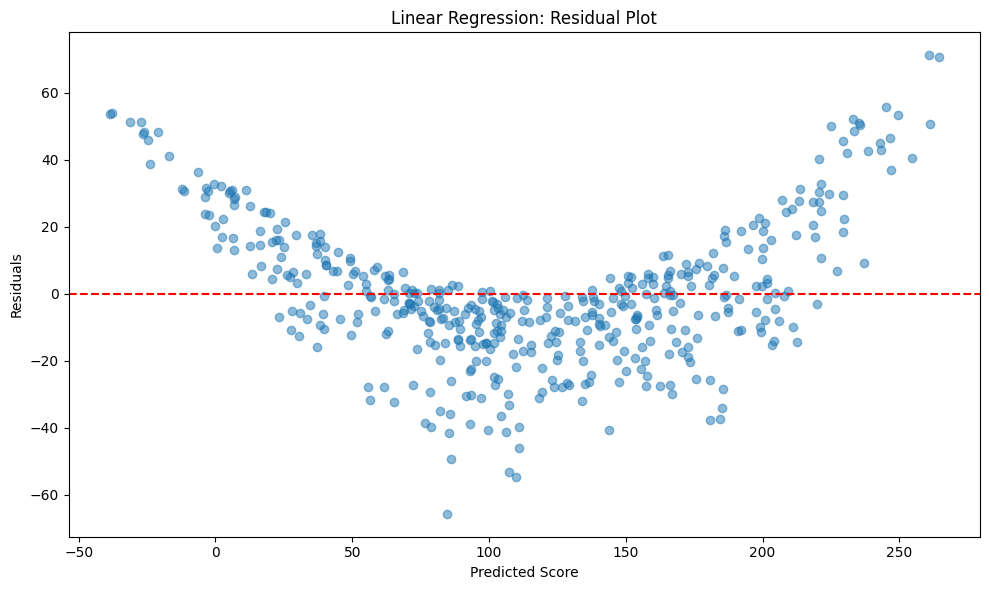

In [28]:
# Visualization: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('Linear Regression: Actual vs Predicted')
plt.tight_layout()
plt.show()

# Residual plot
residuals_lr = y_test - y_pred_lr
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_lr, residuals_lr, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Score')
plt.ylabel('Residuals')
plt.title('Linear Regression: Residual Plot')
plt.tight_layout()
plt.show()

## Model 2: Decision Tree Regressor

In [29]:
# Train Decision Tree model
dt_model = DecisionTreeRegressor(max_depth=10, min_samples_split=10, random_state=42)
dt_model.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluation
dt_mse = mean_squared_error(y_test, y_pred_dt)
dt_rmse = np.sqrt(dt_mse)
dt_mae = mean_absolute_error(y_test, y_pred_dt)
dt_r2 = r2_score(y_test, y_pred_dt)

print("Decision Tree Results:")
print(f"MSE: {dt_mse:.2f}")
print(f"RMSE: {dt_rmse:.2f}")
print(f"MAE: {dt_mae:.2f}")
print(f"R² Score: {dt_r2:.4f}")

Decision Tree Results:
MSE: 239.17
RMSE: 15.46
MAE: 11.23
R² Score: 0.9531


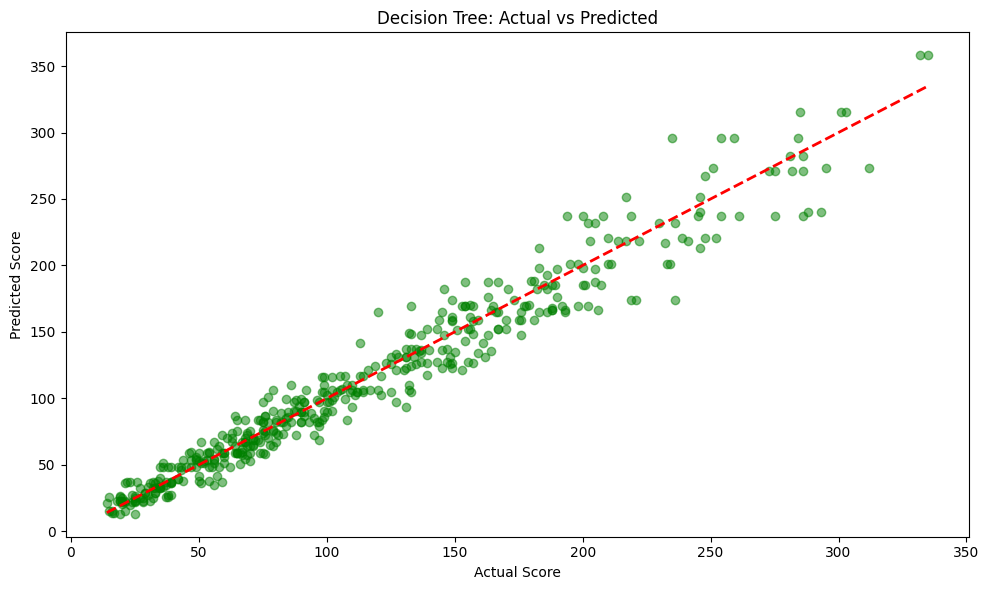

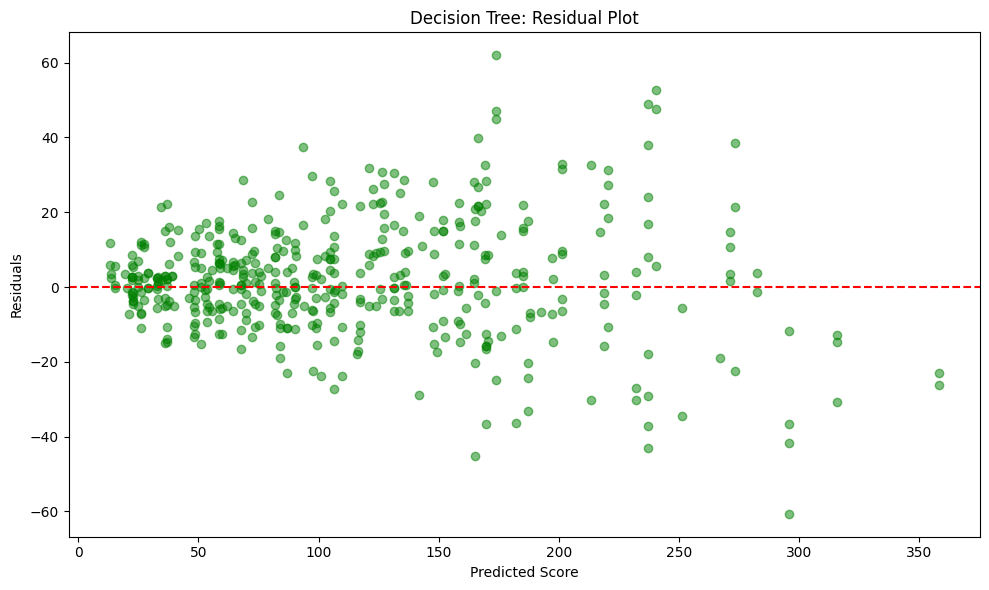

In [30]:
# Visualization: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_dt, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('Decision Tree: Actual vs Predicted')
plt.tight_layout()
plt.show()

# Residual plot
residuals_dt = y_test - y_pred_dt
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_dt, residuals_dt, alpha=0.5, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Score')
plt.ylabel('Residuals')
plt.title('Decision Tree: Residual Plot')
plt.tight_layout()
plt.show()

## Model 3: Neural Network

In [31]:
# Build Neural Network model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile model
nn_model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mse',
                 metrics=['mae'])

nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,545 (49.00 KB)

 Trainable params: 12,545 (49.00 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Train Neural Network
history = nn_model.fit(X_train, y_train,
                       epochs=50,
                       batch_size=32,
                       validation_data=(X_test, y_test),
                       verbose=1)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 16547.2051 - mae: 108.7838 - val_loss: 15800.9863 - val_mae: 103.9471
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13368.1611 - mae: 92.1673 - val_loss: 3140.1411 - val_mae: 43.7192
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2670.2180 - mae: 40.7632 - val_loss: 1149.6011 - val_mae: 25.7250
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 847.8325 - mae: 21.5273 - val_loss: 466.4159 - val_mae: 16.0022
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 408.3975 - mae: 14.2392 - val_loss: 249.0197 - val_mae: 11.9603
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 252.0081 - mae: 12.0493 - val_loss: 199.7303 - val_mae: 10.9530
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 201.0295 - mae: 10.9586 - val_loss: 165.5619 - val_mae: 9.9721
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 166.6805 - mae: 10.2038 - val_loss: 139.6510 - val_mae: 8.9992
Epoch 9/50
33/

In [33]:
# Predictions
y_pred_nn = nn_model.predict(X_test, verbose=0).ravel()

# Evaluation
nn_mse = mean_squared_error(y_test, y_pred_nn)
nn_rmse = np.sqrt(nn_mse)
nn_mae = mean_absolute_error(y_test, y_pred_nn)
nn_r2 = r2_score(y_test, y_pred_nn)

print("Neural Network Results:")
print(f"MSE: {nn_mse:.2f}")
print(f"RMSE: {nn_rmse:.2f}")
print(f"MAE: {nn_mae:.2f}")
print(f"R² Score: {nn_r2:.4f}")

Neural Network Results:
MSE: 4.17
RMSE: 2.04
MAE: 1.55
R² Score: 0.9992


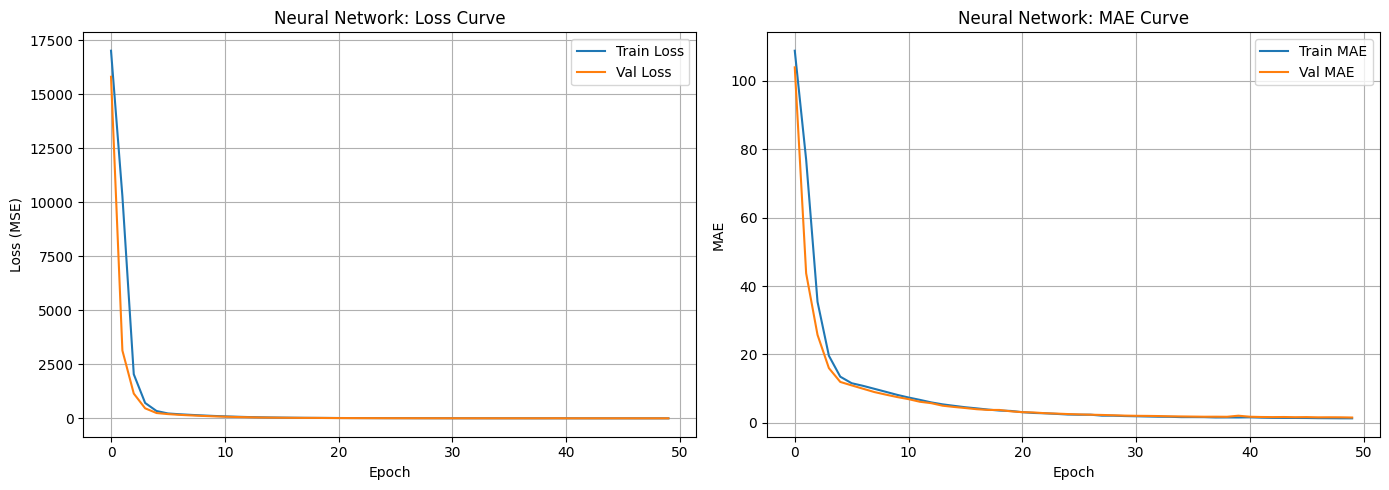

In [34]:
# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Neural Network: Loss Curve')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Neural Network: MAE Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

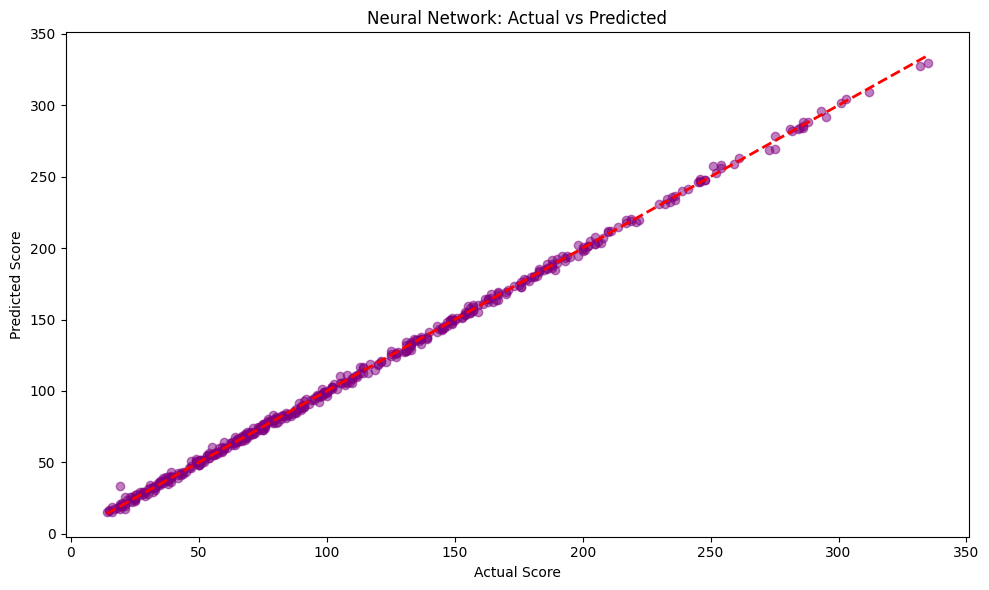

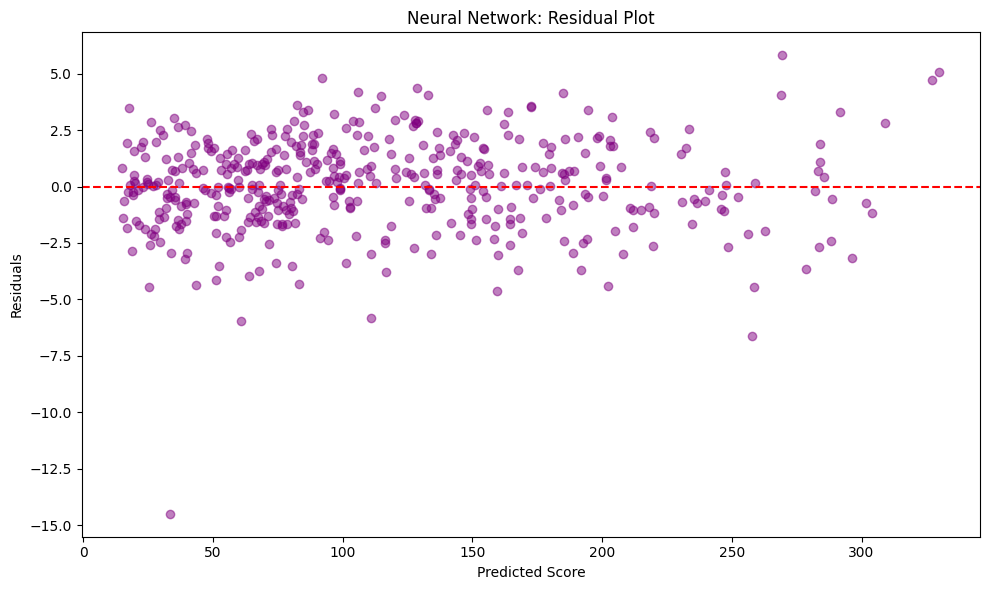

In [35]:
# Visualization: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.5, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('Neural Network: Actual vs Predicted')
plt.tight_layout()
plt.show()

# Residual plot
residuals_nn = y_test - y_pred_nn
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_nn, residuals_nn, alpha=0.5, color='purple')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Score')
plt.ylabel('Residuals')
plt.title('Neural Network: Residual Plot')
plt.tight_layout()
plt.show()

## Model Comparison


Model Comparison:


,Model,MSE,RMSE,MAE,R² Score
0,Linear Regression,444.134666,21.074503,15.758781,0.912928
1,Decision Tree,239.165310,15.464970,11.229399,0.953112
2,Neural Network,4.165402,2.040932,1.551342,0.999183


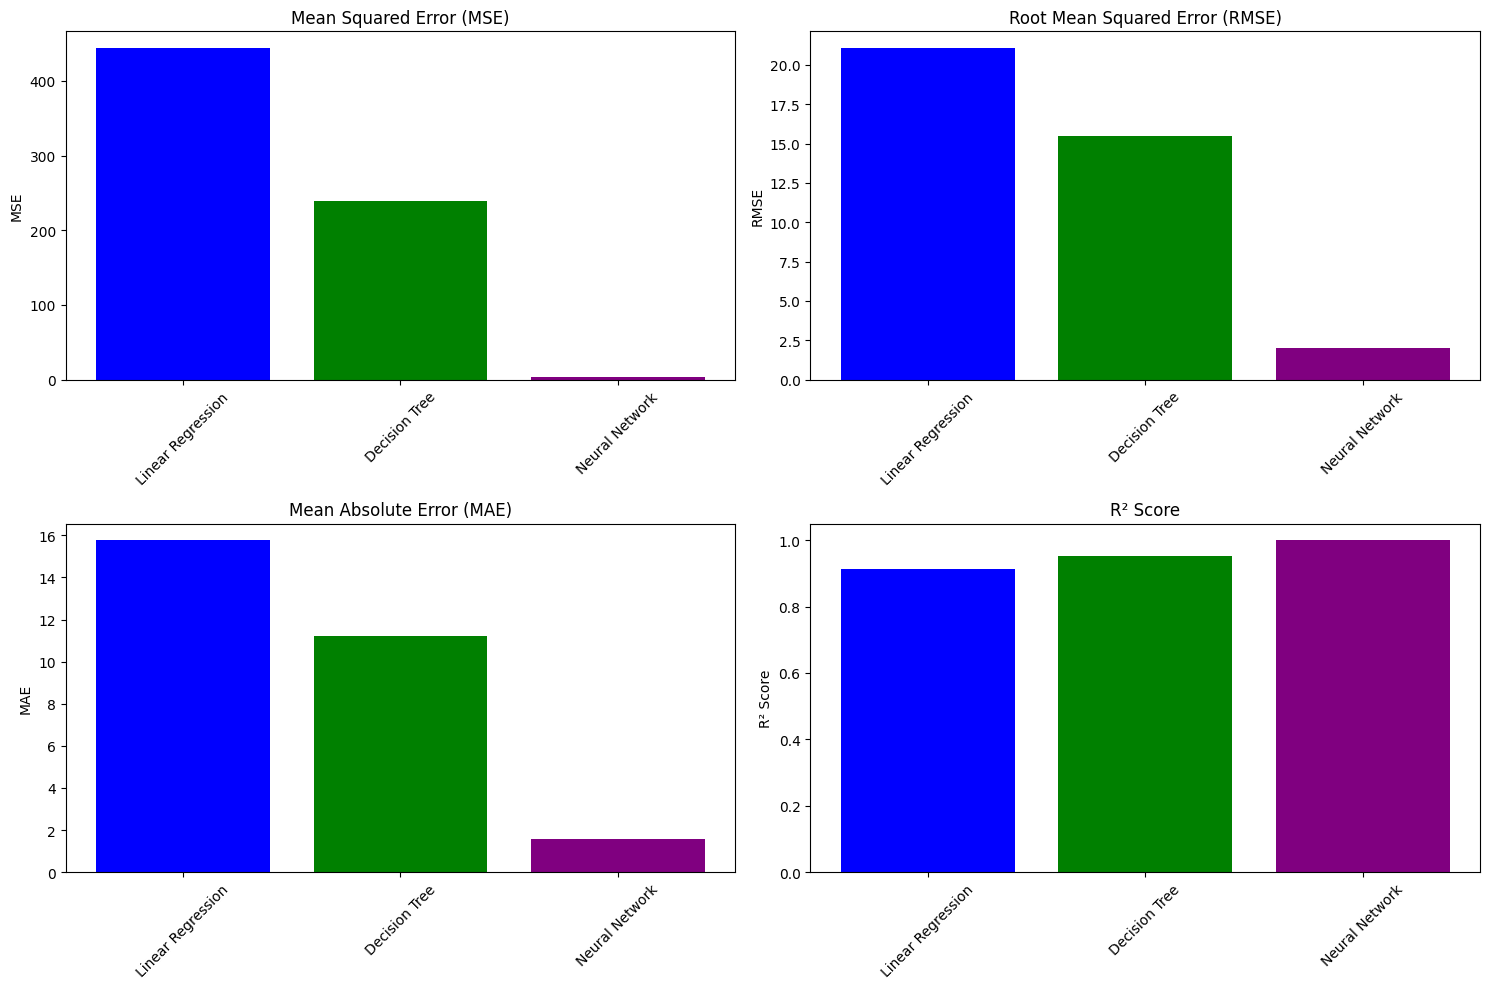

In [36]:
# Comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Neural Network'],
    'MSE': [lr_mse, dt_mse, nn_mse],
    'RMSE': [lr_rmse, dt_rmse, nn_rmse],
    'MAE': [lr_mae, dt_mae, nn_mae],
    'R² Score': [lr_r2, dt_r2, nn_r2]
})

print("\nModel Comparison:")
display(comparison_df)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# MSE comparison
axes[0, 0].bar(comparison_df['Model'], comparison_df['MSE'], color=['blue', 'green', 'purple'])
axes[0, 0].set_title('Mean Squared Error (MSE)')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].tick_params(axis='x', rotation=45)

# RMSE comparison
axes[0, 1].bar(comparison_df['Model'], comparison_df['RMSE'], color=['blue', 'green', 'purple'])
axes[0, 1].set_title('Root Mean Squared Error (RMSE)')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].tick_params(axis='x', rotation=45)

# MAE comparison
axes[1, 0].bar(comparison_df['Model'], comparison_df['MAE'], color=['blue', 'green', 'purple'])
axes[1, 0].set_title('Mean Absolute Error (MAE)')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].tick_params(axis='x', rotation=45)

# R² comparison
axes[1, 1].bar(comparison_df['Model'], comparison_df['R² Score'], color=['blue', 'green', 'purple'])
axes[1, 1].set_title('R² Score')
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## K-Fold Cross Validation

### K-Fold for Linear Regression

In [37]:
# K-Fold CV for Linear Regression
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lr_cv_scores = cross_val_score(lr_model, X_processed, y, cv=kf,
                                scoring='neg_mean_squared_error')
lr_cv_rmse = np.sqrt(-lr_cv_scores)

print("Linear Regression - K-Fold CV:")
print(f"RMSE per fold: {lr_cv_rmse}")
print(f"Mean RMSE: {lr_cv_rmse.mean():.2f}")
print(f"Std RMSE: {lr_cv_rmse.std():.2f}")

Linear Regression - K-Fold CV:
RMSE per fold: [21.01047264 23.10808782 20.01669522 20.37990444 21.04336451]
Mean RMSE: 21.11
Std RMSE: 1.07


### K-Fold for Decision Tree

In [38]:
# K-Fold CV for Decision Tree
dt_cv_scores = cross_val_score(dt_model, X_processed, y, cv=kf,
                                scoring='neg_mean_squared_error')
dt_cv_rmse = np.sqrt(-dt_cv_scores)

print("Decision Tree - K-Fold CV:")
print(f"RMSE per fold: {dt_cv_rmse}")
print(f"Mean RMSE: {dt_cv_rmse.mean():.2f}")
print(f"Std RMSE: {dt_cv_rmse.std():.2f}")

Decision Tree - K-Fold CV:
RMSE per fold: [14.50620916 15.45324884 15.10999598 15.05198982 16.33549443]
Mean RMSE: 15.29
Std RMSE: 0.60


### K-Fold for Neural Network

In [39]:
# K-Fold CV for Neural Network
def build_nn():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_processed.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

X_array = np.array(X_processed)
y_array = np.array(y)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
nn_cv_rmse = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_array), 1):
    X_train_fold, X_test_fold = X_array[train_idx], X_array[test_idx]
    y_train_fold, y_test_fold = y_array[train_idx], y_array[test_idx]

    model = build_nn()
    model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=32, verbose=0)

    y_pred_fold = model.predict(X_test_fold, verbose=0).ravel()
    rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    nn_cv_rmse.append(rmse)
    print(f"Fold {fold} RMSE: {rmse:.2f}")

print(f"\nNeural Network - K-Fold CV:")
print(f"Mean RMSE: {np.mean(nn_cv_rmse):.2f}")
print(f"Std RMSE: {np.std(nn_cv_rmse):.2f}")

Fold 1 RMSE: 2.54
Fold 2 RMSE: 2.75
Fold 3 RMSE: 2.62
Fold 4 RMSE: 3.16
Fold 5 RMSE: 2.36

Neural Network - K-Fold CV:
Mean RMSE: 2.68
Std RMSE: 0.27


## K-Means Clustering

In [40]:
# Elbow method to find optimal K
K_range = range(1, 11)
sse = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_processed)
    sse.append(km.inertia_)

# Find elbow automatically
kl = KneeLocator(K_range, sse, curve='convex', direction='decreasing')
best_k = kl.knee
print(f"Optimal K (Elbow Point) = {best_k}")

Optimal K (Elbow Point) = 5


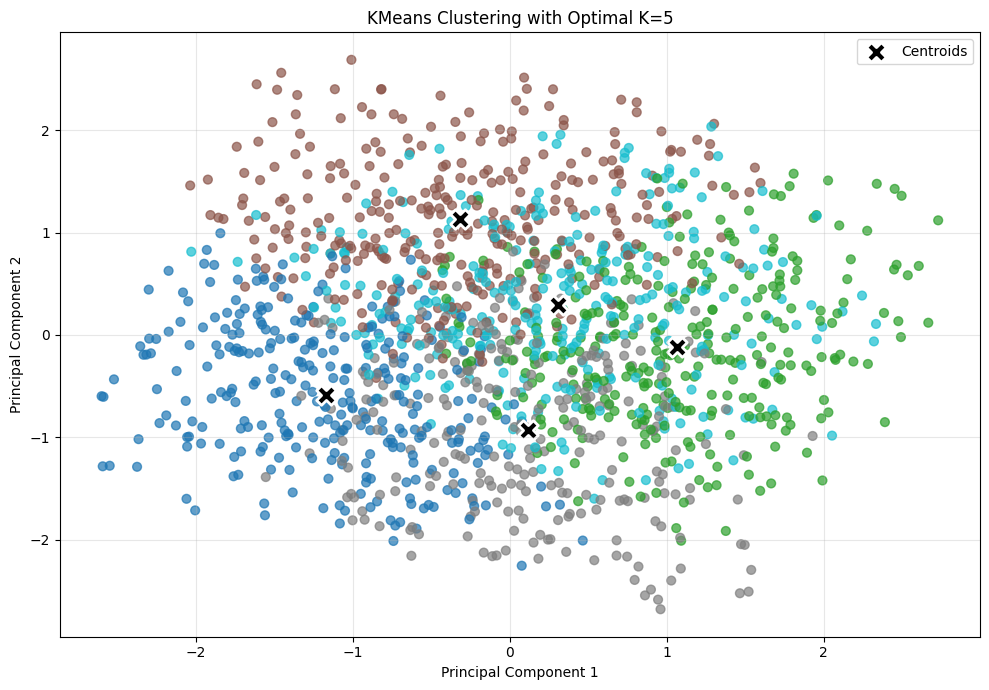

In [41]:
# Fit KMeans with optimal K
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_processed)

# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)
centers_pca = pca.transform(kmeans.cluster_centers_)

# Plot clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', s=40, alpha=0.7)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', marker='X',
            s=200, label='Centroids', edgecolors='white', linewidths=2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'KMeans Clustering with Optimal K={best_k}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

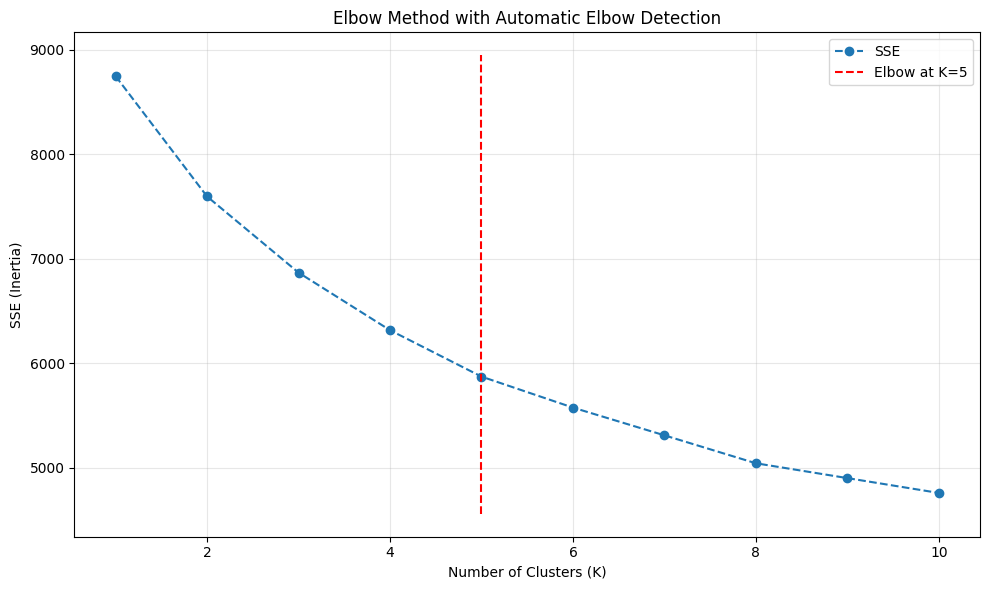

In [42]:
# Plot Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, sse, marker='o', linestyle='--', label='SSE')
plt.vlines(best_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed',
           colors='red', label=f'Elbow at K={best_k}')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method with Automatic Elbow Detection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Conclusion

This notebook demonstrates:
1. **Exploratory Data Analysis** of T20 cricket match data
2. **Data preprocessing** including encoding and scaling
3. **Three regression models**: Linear Regression, Decision Tree, and Neural Network
4. **Model evaluation** using MSE, RMSE, MAE, and R² metrics
5. **K-Fold Cross Validation** for robust performance estimation
6. **K-Means Clustering** to identify patterns in the data

The best model can be selected based on the lowest RMSE/MAE and highest R² score.